# Анализ основных преобразований признаков

На базовой модели оценивается какую роль играют те или иные преобразования признаков.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
from utils import TARGET_FEATURE, FIGSIZE, DATAFILE_NAMES, RANDOM_SEED, load, train_split, target_split
from features import *
from baseline import baseline_classification_score, baseline_clusterization_score

In [3]:
dfs = [load(file_name) for file_name in DATAFILE_NAMES]

In [4]:
COLORS = 'rbgk'
STYLES = ['-', '--', ':', '-.']

In [5]:
def test(df):
    """ test baseline model on df """
    # classification is switched off
    # return baseline_classification_score(df) | baseline_clusterization_score(df)
    return baseline_clusterization_score(df)

def test_all_df(dfs, **kwargs):
    """ test baseline model on all df in dfs """
    return [kwargs | {'dataframe': i} | test(df) for i, df in enumerate(dfs, 1)]

def test_all_df_with_fun(fun, dfs=dfs, **kwargs):
    """ test baseline on all dfs that were processed with fun """
    return test_all_df(map(fun, dfs), **kwargs)

def test_all_df_with_funs(funs, dfs=dfs, **kwargs):
    """ test baseline on all dfs that were processed with funs"""
    dfs_new = []
    for df in dfs:
        for fun in funs:
            df = fun(df)
        dfs_new.append(df)
    return test_all_df(dfs_new, **kwargs)

## Значения метрик на исходных выборках

Размеры выборок уменьшены, чтобы считалось побыстрее.

In [6]:
# pd.DataFrame(test_all_df(dfs))

## Удаление коррелирующих признаков (по Пирсону) не изменяет метрику

Так как признаков очень много и их набор случаен (для разных датасетов), то использовать мощные библиотеки типа phik смысла особого нет - они слишком времязатратны. Поэтому оценка корреляций производится с использованием коэффициента Пирсона.

In [7]:
def test_corr(funs, max_corrs):
    res = []
    for corr in tqdm(max_corrs):
        ndfs = []
        for df in dfs:
            for fun in funs[:-1]:
                df = fun(df)
            ndfs.append(funs[-1](df, corr))
        res.extend(test_all_df(ndfs, corr=corr))
    r = pd.DataFrame(res)
    display(r)
    
    _, ax = plt.subplots(figsize=FIGSIZE)
    for idf, dataframe in enumerate(r['dataframe'].unique()):
        r0 = r[r['dataframe'] == dataframe]
        for im, metric in enumerate(np.setdiff1d(r.columns, ['corr', 'dataframe'])):
            ax.plot(r0['corr'], r0[metric], label=f'{metric}_{dataframe}', c=COLORS[idf], ls=STYLES[im])
    ax.legend()

In [8]:
# %%time
# test_corr([del_corr], np.arange(0.6, 0.96, 0.05))

**Вывод**: При удалении признаков метрики падают. Наиболее оптимальное значение для удаления признаков - значение коэффициента корреляции более 0,7 (тут все спорно, но мне кажется, что так).

Заменяем коррелирующие признаки суммой их модулей.

  0%|          | 0/4 [00:00<?, ?it/s]

,corr,dataframe,ri,mis
0,0.6,1,0.771425,1.212888
1,0.6,2,0.855023,1.219061
2,0.7,1,0.771972,1.231851
3,0.7,2,0.845581,1.201101
4,0.8,1,0.771870,1.239733
5,0.8,2,0.838544,1.159242
6,0.9,1,0.772204,1.258434
7,0.9,2,0.839465,1.185454


Wall time: 1min 23s


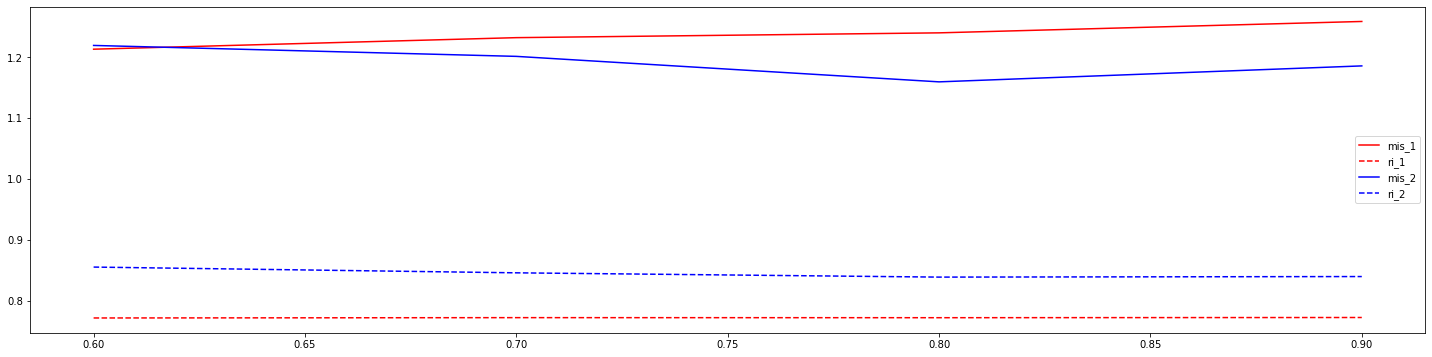

In [9]:
# %%time
# test_corr([replace_corr], np.arange(0.6, 0.96, 0.1))

**Вывод**: При замене коррелирующих признаков своей линейной комбинацией метрика изменяется очень слабо.

Заменяем коррелирующие признаки суммой их модулей с предварительной нормализацией коррелирующих признаков.

  0%|          | 0/4 [00:00<?, ?it/s]

,corr,dataframe,ri,mis
0,0.6,1,0.639227,0.899892
1,0.6,2,0.847196,1.196774
2,0.7,1,0.687748,0.966916
3,0.7,2,0.800278,1.015078
4,0.8,1,0.725515,0.913371
5,0.8,2,0.810023,0.997967
6,0.9,1,0.701580,0.864767
7,0.9,2,0.809107,0.981430


Wall time: 1min 34s


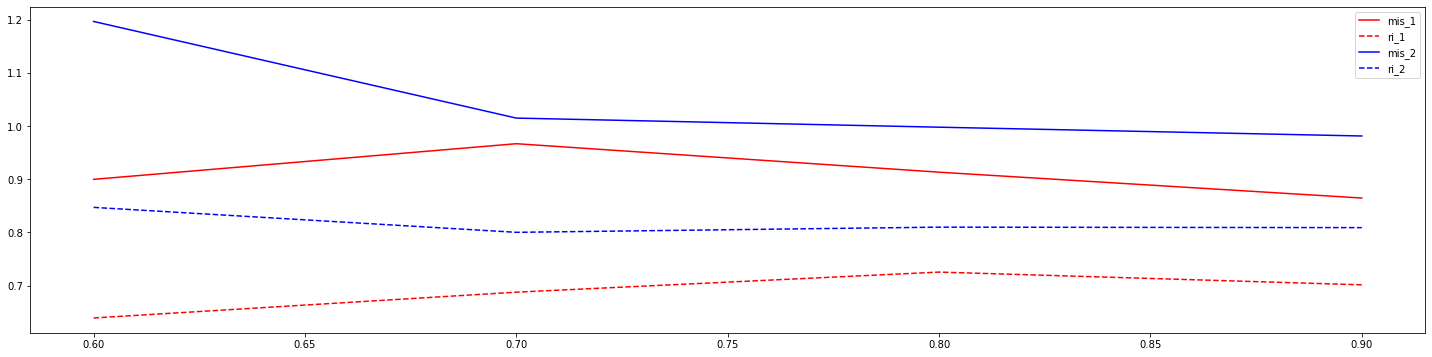

In [10]:
# %%time
# test_corr([lambda df, corr: replace_corr(df, corr, normalize=True)], np.arange(0.6, 0.96, 0.1))

  0%|          | 0/4 [00:00<?, ?it/s]

,corr,dataframe,ri,mis
0,0.6,1,0.705426,1.189093
1,0.6,2,0.841876,1.235169
2,0.7,1,0.706996,1.217779
3,0.7,2,0.834393,1.226828
4,0.8,1,0.738604,1.211495
5,0.8,2,0.835050,1.225698
6,0.9,1,0.707629,1.221558
7,0.9,2,0.836806,1.255052


Wall time: 1min 53s


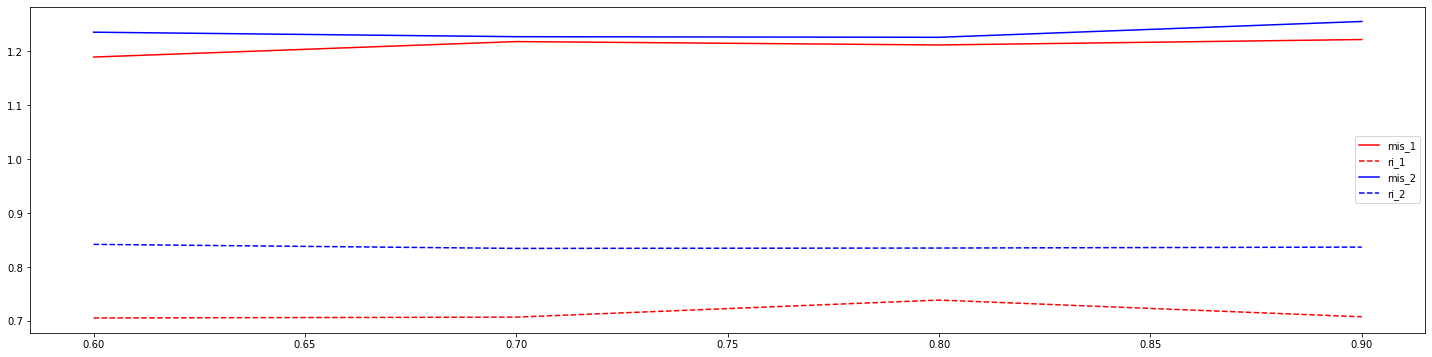

In [12]:
# %%time
# test_corr([t_min_max, replace_corr], np.arange(0.6, 0.96, 0.1))

## Добавление новых признаков улучшает метрику

In [13]:
funss = [[f_abs], [f_abs2], [f_abs05],
         [t_q_q, f_abs], [t_q_q, f_abs2], [t_q_q, f_abs05],
         [t_min_max, f_abs], [t_min_max, f_abs2], [t_min_max, f_abs05]]
funss = [[t_min_max, f_abs], [t_min_max, f_abs2], [t_min_max, f_abs05]]
for funs in tqdm(funss):
    print(funs)
    display(pd.DataFrame(test_all_df_with_funs(funs)))

  0%|          | 0/3 [00:00<?, ?it/s]

[<function apply_nf.<locals>.temp at 0x000001C4ABBE5160>, <function apply_nf.<locals>.temp at 0x000001C4ABBE59D0>]


,dataframe,ri,mis
0,1,0.680536,1.072155
1,2,0.835663,1.216685


[<function apply_nf.<locals>.temp at 0x000001C4ABBE5160>, <function apply_nf.<locals>.temp at 0x000001C4ABBE5AF0>]


,dataframe,ri,mis
0,1,0.659747,1.072462
1,2,0.831014,1.219460


[<function apply_nf.<locals>.temp at 0x000001C4ABBE5160>, <function apply_nf.<locals>.temp at 0x000001C4ABBE5C10>]


,dataframe,ri,mis
0,1,0.661481,1.046140
1,2,0.836162,1.210419
